# TDDFT and SAE of a single atom 
Authors:
 - Gergely Nagy (ELI-ALPS)
 - Kalyani Chordiya (ELI-ALPS)
 - Saibabu Madas (ELI-ALPS)
 - Mousumi Upadhyay Kahaly (ELI-ALPS)

Using the lewenstein integral method one cannot account for the multi-electron contribution when it comes to a molecular system. Hence a quantum description which can include the multielectron dynamics is necessary. One such method is using time dependent density functional theory (TDDFT).

In TDDFT method, using Runge-Gross theorem a one-to-one correspondance between the time dependent potentials and densities is established. Hence the TDKS equation is given by:

$$i\frac{\partial}{\partial~t}\phi_i(r,t) = [-\frac{\nabla^2}{2}+V_{ks}[n](r,t)]\phi_i(r,t)$$

$V_{ks}[n](r,t) = V_{ext}(r,t) + V_H[n](r,t)+ V_{XC}[n](r,t)$: KS potential given by one body external potential, non-interacting Hartree potential and XC potential.

$V_H[n](r,t) = \int dr^\prime \frac{n(r^\prime ,t)}{|r-r^\prime|}$: Hartree potential

$\phi_i(r,t)$: KS orbital

$n(r,t) = \sum_i^{N}|\phi_i(r,t)|^2$: Time dependent densiyt of N-interacting systems

Using the time dependent density, one can calculate the time dependent dipole moment:

$$d(t) = \int dr~r n(r,t) = \sum_j \int dr~r|\phi_j(r,t)|^2$$

The dipole moment acceleration can be calculated using the above time dependent dipole moment.

$$a(t) = \frac{d^2}{dt^2}d(t) = -\int dr~n(r,t)\nabla~V_{ks}(r,t)$$

Taking the fourier transform of the induced dipole moment modulus squared we can calculate the harmonic generation dipole power spectrum.

$$P(\omega) = \frac{1}{t_f^2}\begin{vmatrix}\int_0^{t_f}dt~e^{-i\omega~t}d(t)\end{vmatrix}^2$$

Similarly, taking the fourier transform of the dipole moment acceleration, one can get the harmonic spectrum in the direction of polarization:
$$
H(\omega) = \frac{1}{t_f^2}\begin{vmatrix}\int_0^{t_f}dt~e^{-i\omega~t}a(t)\end{vmatrix}^2
$$

In this tutorial we will first calculate the time dependent dipole moment using the TDDFT method implemented in the [Octopus code](https://octopus-code.org/wiki/Main_Page). First, we consider an isolated Xenon atom.

## Technical prelude

First, some technical code:

We will utilize the [Atomic Simulation Enfironment](https://wiki.fysik.dtu.dk/ase/index.html) module. If you don't have it already, you can install with
```
pip install ase
```
or 
```
conda install -c conda-forge ase
```
if you're using Conda.

In [2]:
import sys
import os
import shutil
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
from scipy import constants as const
from ase import io, Atom, Atoms

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120   # make figures larger

In [4]:
notebook_path = os.getcwd()
print(notebook_path)

/home/nagyg/Projects/ElissNotebook/Codes/panosc-summerschool-2022/02_Tuesday_September_13th


If your Octopus binaries are in a local folder, add it to `$PATH` here. If they are already there, you can skip the cell below. This works for Linux; on Windows, you have to make sure that Octopus is visible for the system yourself.

In [5]:
Octopus_bin_path = os.environ["HOME"]+"/.local/Octopus/bin"
os.environ['PATH']= ":".join([Octopus_bin_path, os.environ['PATH']])

This folder will be used for the files created while running the simulations.

In [6]:
tmpdir=os.path.abspath(os.path.join(notebook_path, 'calc_atomic'))
# ensure unique name
# i=1
# while os.path.isdir(tmpdir):
#     i += 1
    # tmpdir=os.path.abspath(os.path.join(notebook_path, f'calc_atomic_{i}'))
os.makedirs(tmpdir,exist_ok=True)
print('Created calculation directory: '+ tmpdir)

Created calculation directory: /home/nagyg/Projects/ElissNotebook/Codes/panosc-summerschool-2022/02_Tuesday_September_13th/calc_atomic


In [7]:
os.chdir(tmpdir)

## Useful definitions

In the following, we define some functions that will come handy later in the simulation and postprocessing.

We use SI-derived quantities, but most DFT and TDDFT software - including Octopus - prefers to work in atomic units. The followings will help us with the conversions.

In [8]:
def au_si_conv(value, quantity, target="au"):
    "Convert units from SI to atomic units and back."
    unit = {}
    #    hbar = 1.054571726e-34
    unit["time"] = unit['t'] = 2.4189e-17  # Value of 1 atomic units in second
    unit["q"] = 1.602176565e-19
    unit["m"] = 9.10938291e-31
    unit["length"] = unit['l'] = 5.291772e-11
    unit["omega"] = unit['w'] = 1 / unit["time"]
    unit["energy_ev"] = unit['ev'] = 27.2114
    unit["energy"] = unit["energy_ev"] * unit["q"]
    unit["c"] = unit["length"] / unit["time"]
    unit["d"] = unit["dipole"] = unit["q"] * unit['l'] # 8.4783536255e-30   # dipole moment
    unit["electricfield"] = unit['E'] = 5.142208e11
    unit["intensity"] = unit['I'] = 3.50944758e20

    if target.lower() == "si":
        return value * unit[quantity]
    elif target.lower() in ["au", "a.u."]:
        return value / unit[quantity]
    elif target == 'factor':
        return unit[quantity]
    else:
        raise ValueError(f"target must be 'SI', 'AU' or 'factor' (given: {target})")

# some important conversion factors as constants
C_AU = 137.035999139
C_NM_FS = 299.792458
FS_TO_AU = 41.341374575751
NM_TO_AU = 18.897259886
EV_TO_AU = 0.036749322176
ANGSTR_TO_AU = NM_TO_AU / 10

In [9]:
0.1/FS_TO_AU

0.002418884254

The harmonic cutoff from an isolated atom can be estimated as
$$
E_{cutoff} = I_p + 3.17*U_p
$$
where $I_p$ is the ionization potential of the atom, and $U_p$ is the ponderomotive energy of the electron in the laser field. In atomic units:
$$
U_p = \frac{I_{laser}}{4\omega^2}
$$

In [10]:
def get_au_cutoff(el_int_au, omega0_au, Ip_ev):
    "Return the cutoff energy (in a.u.) given a laser untensity, frequency, and the Ip in ev."
    Ip = au_si_conv(Ip_ev, "energy_ev")
    Up = el_int_au / (4 * omega0_au ** 2)
    cutoff = Ip + 3.17 * Up
    return cutoff

Octopus input file expects arrays as blocks with items separated by `|`. The following functions help us to write the ASE moleculles in this format:

In [11]:
def array_to_octopus_format(arr):
    if arr.ndim == 1:
        return " | ".join(arr.astype(str).tolist()) 
    elif arr.ndim == 2:
        return "\n".join([" | ".join(arrline.astype(str).tolist()) for arrline in arr])
    else:
        raise ValueError

def coords_to_octopus_format(atom):
    coords = atom.get_scaled_positions() * ANGSTR_TO_AU
    symbols = atom.get_chemical_symbols()
    coordstr = ""
    for sym, coord in zip(symbols, coords):
        coordstr += f'"{sym}" | ' + " | ".join(coord.astype(str).tolist()) + "\n"
    return coordstr


## Simulation setup

Let's choose the atom and the laser parameters for the simulation, as well as the simulation parameters such as the duration and timestep.

#### Parameters and definitions

In [12]:
atom = 'Ar'
Ip_ev = 15.759

In [13]:

pulse_wl = 800                 # Wavelength of the pulse in nm
pulse_I = 1.4e14               # Intensity of the laser pulse in W/cm2 
t_pulse = 3 * pulse_wl/C_NM_FS # duration of the sin2 pulse (half of 0-to-0) in fs
print('t_pulse = ', t_pulse, 'fs')

t_sim = 2*t_pulse+1            # The duration of the simulation in fs.
deltat = 0.008                 # Timestep of the simulation.

cell_size = 20, 20, 20  # x, y, z cell size of the simulation in Angstrom
mesh_spacing = 0.2 # mesh spacing of the Octopus simulation in Angstrom
absorb_width = 2.0 #width of the absorbing boundary in angstrom

fft_t_window = t_sim  # FFT window width used to obtain the HHG spectrum from the dipole moment (controls the spectral resolution by zero-paddingg the time-domain signal)
n_fft = int(fft_t_window // deltat)
print("nsteps = ", int(t_sim / deltat))

t_pulse =  8.00553828475565 fs
nsteps =  2126


Some converted quantities:

In [14]:
pulse_omega = 2*np.pi * C_NM_FS / pulse_wl
pulse_eV = 1.2398 / pulse_wl

t_pulse_au = au_si_conv(t_pulse*const.femto, 't', 'au')
pulse_omega_au = au_si_conv(pulse_omega/const.femto, 'w', 'au')
pulse_I_au = au_si_conv(pulse_I * 1e4, 'I', 'au')
E0_au = np.sqrt(pulse_I_au)

For this simulation, we define the laser in the velocity gauge, or in other words, we use the vector potential description. Given a vector potential $A(t)$, the electric field can be obtained as
$$
E(t) = -\frac{\mathrm{d}}{c\ \mathrm{d}t} A(t)
$$
Furthermore, we use a $sin^2$ pulse: a laser pulse whose envelope is defined by a cycle of the $sin^2(x)$ function. This is similar to a Gaussian pulse, but provides computational advantages as it has a finite length instead of an exponentially disappearing infinite trail. We define it in such a way that it starts at 0, and ends at $2t_p$:
$$
A(t) = A_0 \sin\left(\frac{\pi t}{2 t_p}\right)^2 
           \left(1-\Theta\left(t-2t_p\right)\right)
           \sin(\omega t)
$$

The vector field will be defined in the Octopus input file by the following string. Octopus will take care of the $cos(\omega t)$ multiplier of the derived $E(t)$, so we exclude it.

In [15]:
A0_au = C_AU * E0_au / pulse_omega_au 
vecfield_envelope_expr = (
    f"{A0_au}*(sin(pi*t/(2*{t_pulse_au})))^2*(1-step(t-2*{t_pulse_au}))"
)

#### Setting up things

Let's estimate the cutoff:

In [16]:
e_cutoff = get_au_cutoff(pulse_I_au, pulse_omega_au, Ip_ev)
print(pulse_I_au, pulse_omega_au, Ip_ev)
cutoff_ho = e_cutoff / pulse_omega_au
print(f"Estimated cutoff: {cutoff_ho:.3f} * omega0")

0.003989231832321599 0.056954559702042315 15.759
Estimated cutoff: 27.280 * omega0


Unless you changed the original parameters, we should expect the cutoff at about the 27th harmonic.

In the next step, let's onstruct the atomic coordinates. While using ASE for a single atom is kind of an overkill, it is a handy tool if we would simulate more complex molecules, or would like to automate the process. And the same workflow we use here would work for an arbitrary molecule, which is easy to obtain using ASE. For example, the cell below could also be
```
from ase import molecule
molec = molecule('CH4')
```

and then this notebook would suddenly run the calculations on a $\mathrm{CH}_4$ molecule. We could also download or even create a suitable coordinates file (.xyz, .cif, .pdb...), and load it as 

```
molec = ase.io.read('molec.xyz')
```

Of course, the simulation parameters - such as the cell size, or even the periodicity, for example - would need to be adjusted accordingly, and the TDDFT run would also take much longer.

For now, the "molecule" is trivially simple: a single atom positioned at (0,0,0).

In [17]:
from ase import Atoms
molec = Atoms(atom, positions=[(0., 0., 0.),])

Let's see what did we do:

In [18]:
print(molec.get_chemical_symbols())
print(molec.get_positions())

['Ar']
[[0. 0. 0.]]


In Octopus format, this will look like this:

In [19]:
oct_coords = coords_to_octopus_format(molec)
print(oct_coords)

"Ar" | 0.0 | 0.0 | 0.0



## Ground-state calculation

Now that the setup is done, it's time to execute the Octopus calculation as before. First, we run the ground state calculation. The following cell constructs the input file, and then we write it into the calculation folder. Octopus always looks for the input file at `$PWD/inp`.

In [20]:
gs_input = f"""
FromScratch = yes
CalculationMode = gs            # ground-state calculation
ConvEigenError = true           # 
EigensolverTolerance = 1e-9
# PeriodicDimensions = 0

Spacing = {mesh_spacing}*angstrom
ExtraStates = 0

BoxShape = parallelepiped
%Lsize 
{cell_size[0]}*angstrom | {cell_size[1]}*angstrom | {cell_size[2]}*angstrom
%

% Coordinates
{oct_coords}%

PseudopotentialSet = hgh_lda
EigenSolver = rmmdiis

# SymmetrizeDensity = no

%Output
 dos
 geometry | xcrysden
%

"""

In [21]:
with open("inp", "w") as f:
    print(gs_input, file=f)

To get more info about the input parameters, you can use the `oct-help` command-line utility.
> *Note: the container used for the summer school doesn't have Octopus installed, so this won't work. If you have it on your own machine, try it there!*

In [22]:
parameter_to_lookup = "EigenSolver"
os.system(f"oct-help -p " + parameter_to_lookup)

Variable: Eigensolver
Type:     integer
Section:  SCF::Eigensolver
Description:
    Which  eigensolver  to  use  to  obtain  the  lowest  eigenvalues  and
    eigenfunctions  of  the  Kohn-Sham  Hamiltonian.  The  default is conjugate
    gradients  (cg), except that when parallelization in states is enabled, the
    default is rmmdiis.
Available options:
  cg
    Conjugate-gradients algorithm.
  plan
    Preconditioned  Lanczos  scheme.  Ref:  Y.  Saad,  A.  Stathopoulos,  J.
    Chelikowsky,  K.  Wu and S. Ogut, "Solution of Large Eigenvalue Problems in
    Electronic Structure Calculations", _BIT_ *36*, 1 (1996).
  cg_new
    An  alternative  conjugate-gradients eigensolver, faster for larger systems
    but less mature. Ref: Jiang et al., _Phys. Rev. B_ *68*, 165337 (2003)
  evolution
    (Experimental) Propagation in imaginary time.
  rmmdiis
    Residual  minimization  scheme,  direct inversion in the iterative subspace
    eigensolver,  based  on  the  implementation of Kresse a

0

Time to run the Octopus calculation. The ground state should be finished in a few seconds, since we only have a single atom. For this tutorial, we already executed it, but feel free to try yourself.

In [23]:
RUN_GS = False
if RUN_GS:
    os.system("octopus | tee octopus_gs.log")

Let's check the convergence by plotting the energy differences between the consecutive steps on a logarithmic scale. If all goes well, we should see a roughly exponential decrease.

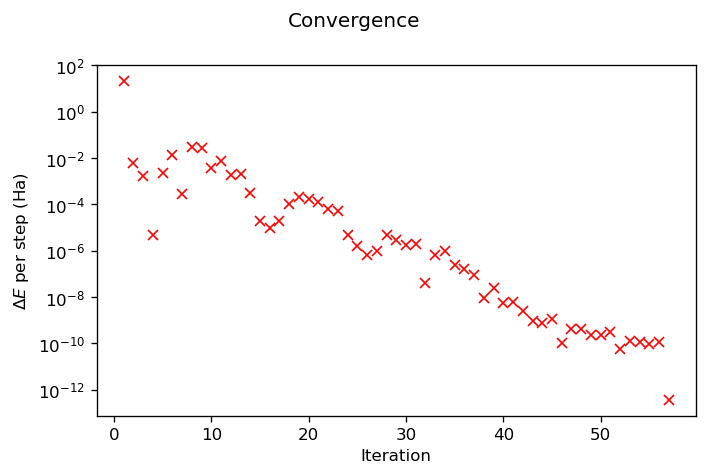

In [24]:
iter, energy, energy_diff, abs_dens, rel_dens, abs_ev, rel_ev = np.genfromtxt("static/convergence", skip_header=1, unpack=True)
plt.semilogy(iter, energy_diff, 'rx')
plt.xlabel('Iteration'); plt.ylabel(r'$\Delta E$ per step (Ha)'); plt.suptitle("Convergence"); plt.tight_layout()

Let's also take a glance the DOS. We should see two peaks corresponding to two energy levels.

Efermi =  -0.380758


Text(0, 0.5, 'DOS')

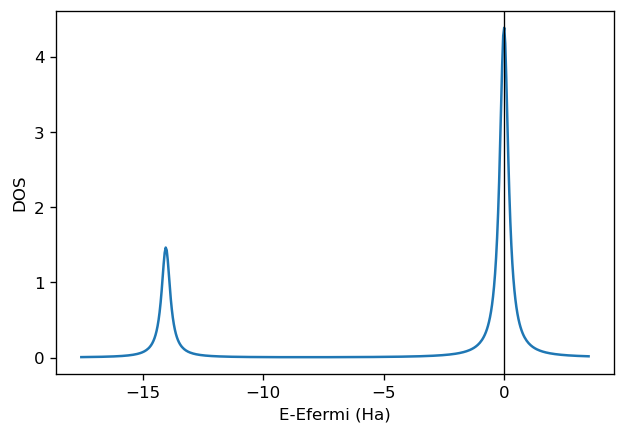

In [25]:
(efermi, _), _ = np.genfromtxt("static/total-dos-efermi.dat", skip_header=1, unpack=True)
doseng, dos = np.genfromtxt("static/total-dos.dat", skip_header=1, unpack=True)

print("Efermi = ", efermi)
plt.plot((doseng-efermi) / EV_TO_AU, dos * EV_TO_AU)
plt.axvline(0, color='k', linewidth=0.8)
plt.xlabel("E-Efermi (Ha)")
plt.ylabel("DOS")

Everything seems fine, so it's time to create the input file for the propagation.

In [26]:
td_input = f'''
#---> Calculation Mode
CalculationMode = td
Dimensions = 3
PeriodicDimensions = 0

#---> Structure of lattice
Spacing = {mesh_spacing}*angstrom
BoxShape = parallelepiped

%Lsize 
{cell_size[0]}*angstrom | {cell_size[1]}*angstrom | {cell_size[2]}*angstrom
%

% Coordinates
{oct_coords}%

#-------------------> THEORY LEVEL <----------------------------------------#
LCAOStart = lcao_states
PseudopotentialSet = hgh_lda
EigenSolver = rmmdiis
ExtraStates = 0

#--> Parallelisation
ParDomains = auto
ParStates  = auto

ConvRelDens = 1e-7
#----------------------TD-Part------------------------------------#
# read restart
%RestartOptions
  restart_gs | "./restart"
%

TDPropagator = aetrs
TDExponentialMethod = lanczos
TDExpOrder = 16

FFTLibrary = fftw

TDPropagationtime = {t_sim}/0.024 # in a.u.
TDTimeStep = {deltat}/0.024   # in a.u.

AbsorbingBoundaries = cap
ABCapHeight = -1
ABWidth={absorb_width}*angstrom

# %ABShape
# ({cell_size[0]}-{absorb_width})*angstrom | {cell_size[0]}*angstrom | "abs(z)"
# %

%TDFunctions
    "envelope" | tdf_from_expr | "{vecfield_envelope_expr}"
     "CEP" | tdf_cw | 0
%

omega_au = {pulse_omega_au} 
%TDExternalFields
 vector_potential | 1 | 0 | 0 | omega_au | "envelope" | "CEP"
%

# OutputInterval = 5
# TDOutputComputeInterval = 5

%TDOutput
laser 
dipole_acceleration 
%
'''

Again, you can use the `oct-help` utility to look up the parameters.
> *Note: the container used for the summer school doesn't have Octopus installed, so this won't work. If you have it on your own machine, try it there!*

In [27]:
parameter_to_lookup = "AbsorbingBoundaries"
os.system(f"oct-help -p " + parameter_to_lookup)

Variable: AbsorbingBoundaries
Type:     flag
Default:  not_absorbing
Section:  Time-Dependent::Absorbing Boundaries
Description:
    To improve the quality of the spectra by avoiding the formation of standing
    density  waves, one can make the boundaries of the simulation box absorbing
    and use exterior complex scaling.
Available options:
  not_absorbing
    Reflecting boundaries.
  mask
    Absorbing boundaries with a mask function.
  cap
    Absorbing boundaries with a complex absorbing potential.
  exterior
    Exterior complex scaling (not yet implemented).


0

In [28]:
with open("inp", "w") as f:
    print(td_input, file=f)

Run the time-dependent calculation. On an average system, this takes hours, so for the lesson, we already executed this and obtained the neccessary output files. 

If you want, feel free to test around and run this before/after the lesson. If you installed/complied Octopus with MPI support, you can take advantage of it and use `os.system("mpirun octopus | tee octopus.log")` instead to enjoy a massive speedup.

In [29]:
RUN_TDDFT = False
if RUN_TDDFT:
    print("Number of simulation steps: ", int(t_sim / deltat))
    os.system("octopus | tee octopus.log")

That done, let's load the vector field $A(t)$ Octopus was using, and convert it to electric field $E(t) = \frac{\mathrm{d}A(t)}{c\ \mathrm{d}t}$.  As our laser is polarized in the x direction, we only have to load the x component. In the following, we also have to keep in mind that Octopus (with the current input settings) outputs everything in atomic units.

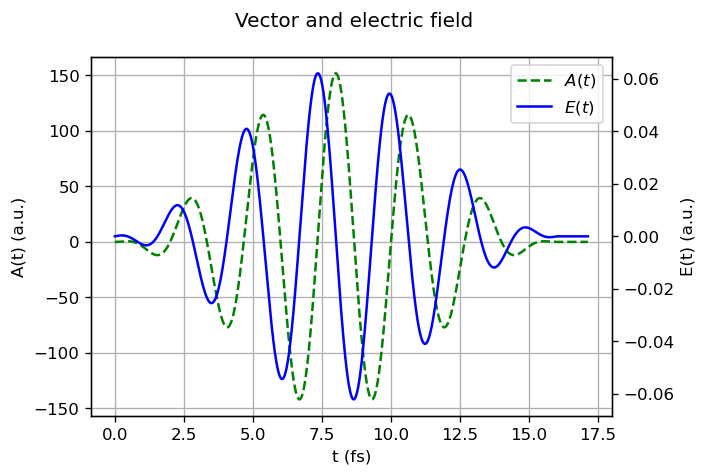

In [30]:
t_au, vecpot_au = np.genfromtxt(os.path.join("td.general", 'laser'), usecols=(1,2), unpack=True)
E_au = np.gradient(vecpot_au, t_au) / C_AU

fig, axa = plt.subplots()
axe = axa.twinx()
p1, = axa.plot(t_au/FS_TO_AU, vecpot_au, 'g--', label=r'$A(t)$')
p2, = axe.plot(t_au/FS_TO_AU, E_au, 'b-', label=r'$E(t)$')

# add labels and title
axa.set_xlabel('t (fs)'); axa.set_ylabel('A(t) (a.u.)'); axe.set_ylabel('E(t) (a.u.)'); fig.suptitle("Vector and electric field")
axa.legend(handles=[p1,p2])
axa.grid()
plt.tight_layout()

Time to calculate the HHG spectrum. As outlined in the beginning, we can calculate this as
$$
H(\omega) = \frac{1}{t_f^2}\begin{vmatrix}\int_0^{t_f}dt~e^{-i\omega~t}a(t)\end{vmatrix}^2
$$
Utilizing the Fourier identity $\mathscr{F}\left\{\frac{\mathrm{d}f(t)}{\mathrm{d}t}\right\} = \mathrm{i}\omega\mathscr{F}\left\{f(t)\right\}$, we can write the above as
$$
H(\omega) = \begin{vmatrix}-\omega^2 \mathscr{F}\left\{d(t)\right\}\end{vmatrix}^2
$$

The code below calculates the HHG spectrum from the dipole moment calculated by Octopus this way. Octopus outputs the dipole moment $d(t)$ by default, which we can use in the second equation, but we can also ask it (by including the `dipole_acceleration` key in the `%TDOutput` card) to calculate the dipole acceleration $a(t)$ itself using the Ehrenfest theorem, and use equation 1.

In case of discrete data, the Discrete Fourier Transform is used to implement the Fourier transform. This corresponds to a Fourier series of a dataset containing N samples of $\{x_1, ..., x_N\}$, sampled at integer points, and defined as 
$$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-\frac{2\pi}{N}kn}
$$
The result is a finite dataset $\{X_1, ...X_k, ..., X_N\}$, which is N-periodic in k. 

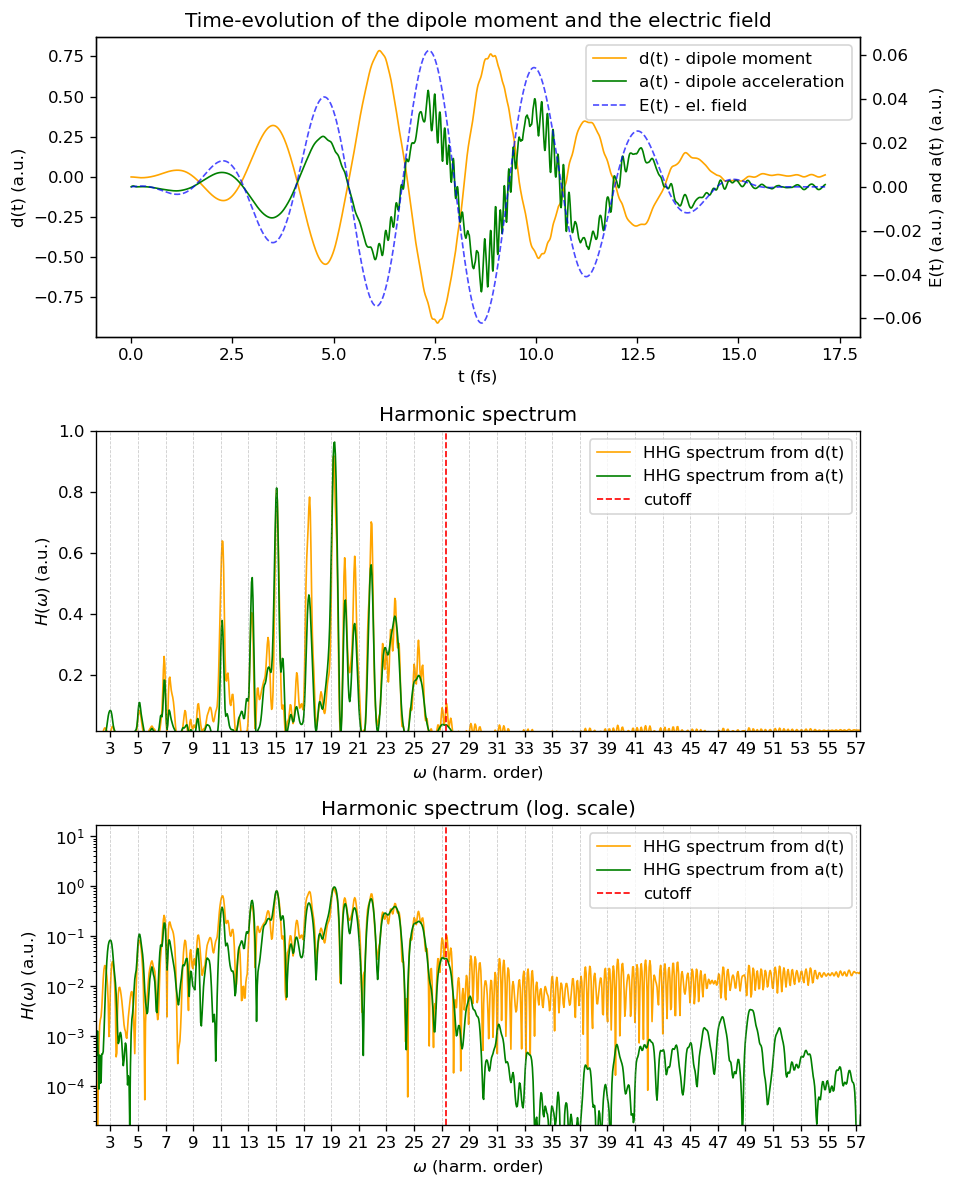

In [48]:
### Read data and calculate FFT ###
fft_t_window = 3*t_sim  # FFT window width used to obtain the HHG spectrum from the dipole moment (controls the spectral resolution by zero-paddingg the time-domain signal)
n_fft = int(fft_t_window // deltat)

fpath = os.path.join("td.general", "multipoles")
fpath2 = os.path.join("td.general", "acceleration")
t_au, dpx, dpy,dpz = np.genfromtxt(fpath, usecols=(1,3,4,5), unpack=True)
t_au, dax, day,daz = np.genfromtxt(fpath2, usecols=(1,2,3,4), unpack=True, skip_header=5)
dipole = dpx # depending on the laser polarization, ours is x-linear
dipole_acc = dax

# do the fft
dt_au = t_au[1] - t_au[0]
oms_au = 2*np.pi*fftshift(fftfreq(n_fft,d = np.abs(dt_au))) # FFT angular frequency
# oms = 2*np.pi*fftshift(fftfreq(t_au.size,d = np.abs(dt))) # FFT angular frequency
ft_d = - fftshift(fft(dipole, n=n_fft)) * oms_au**2
ft_da = fftshift(fft(dipole_acc, n=n_fft))
hhg = np.abs(ft_d)**2
hhg_a = np.abs(ft_da)**2

# the harmonic orders
ho = oms_au / pulse_omega_au
t_si = t_au / FS_TO_AU

# plot the laser field and the dipole moment VS time
fig, (axt, axw, axwl) = plt.subplots(3,1, figsize=(8,10))
axl = axt.twinx()
p1, = axt.plot(t_si, dipole, 'orange', linewidth=1.0, label='d(t) - dipole moment')
p11, = axl.plot(t_si, dipole_acc, 'green', linewidth=1.0, label='a(t) - dipole acceleration')
p2, = axl.plot(t_si, E_au, 'blue', alpha=0.7, linestyle='--', linewidth=1.0, label='E(t) - el. field')
axt.set_xlabel('t (fs)')
axt.set_ylabel('d(t) (a.u.)')
axl.set_ylabel('E(t) (a.u.) and a(t) (a.u.)')
axt.set_title("Time-evolution of the dipole moment and the electric field")
axl.legend(handles=[p1, p11, p2])

# plot the HHG spectra
for ax in (axw, axwl):
    p3, = ax.plot(ho, hhg, 'orange', linewidth=1.0, label='HHG spectrum from d(t)')
    p31, = ax.plot(ho, hhg_a, 'green', linewidth=1.0, label='HHG spectrum from a(t)')
    ax.set_xticks([1+2*i for i in range(50)])
    ax.set_xlim(2, cutoff_ho+30)
    for i in range(50):
        ax.axvline(1+2*i, linewidth=0.5, linestyle='--', color='gray', alpha=0.4)
    p4 = ax.axvline(cutoff_ho, linewidth=1.0, linestyle='--', color='red', label='cutoff')
    ax.set_xlabel(r'$\omega$ (harm. order)')
    ax.set_ylabel(r'$H(\omega)$ (a.u.)')
    ax.legend(loc='upper right', handles=[p3, p31, p4])

axw.set_title("Harmonic spectrum")
axwl.set_title("Harmonic spectrum (log. scale)")
axw.set_ylim(np.amax(hhg)*1e-2, 1.0)
axwl.set_ylim(np.amax(hhg)*1e-5, np.amax(hhg)*1e1)
axwl.set_yscale('log')
plt.tight_layout()

We an compare this to an experimental result, for example to this one:

![Experimental HHG](images/hhg_exp_ref.png "Experimental HHG")

*Riedel et. al. (2001). Tunable pulsed vacuum ultraviolet light source for surface science and materials spectroscopy based on high order harmonic generation. Review of Scientific Instruments. 72. 1977-1983. 10.1063/1.1351835.*

The above spectrum was obtained from an argon jet using a tunable Ti:sapphire laser source with an $1.4 \cdot 10^{14}\frac{\mathrm{W}}{\mathrm{cm}^2}$ intensity and a $t_p=120\mathrm{fs}$ pulse duration. Our result shows similar cutoff and reproduces the peaks at the odd harmonic orders. However, we can also observe more noise and a difference in the peak heights. This could be improved by increasing the accuracy of the calculations: increase the bounding box, decrease the mesh spacing, decrease the time step. These changes however would also be reflected in the calculation time.

### Lewenstein model using HHGMax

Let's compare our result with the Lewenstein model, using the same code as in the previous notebook. After some appropiate unit conversions, we feed the code the electric field we got from the Octopus run, and then calculate the HHG spectrum from the dipole moment the same way as before.

In [32]:
from hhgmax import pylewenstein as pylew

wl_si = pulse_wl*const.nano
# fwhm_si = t_pulse*const.femto
Ip_si = Ip_ev * const.electron_volt
# pulse_I_si = pulse_I * 1e4  #W/cm2 to W/m2
t_si = au_si_conv(t_au, 't', 'si')
E_si = au_si_conv(E_au, 'E', 'si')
oms_si = au_si_conv(oms_au, 'omega', 'si')

d_lew_si = pylew.lewenstein(t_si, E_si, Ip_si, wl_si, weights=np.ones_like(t_si), )
d_lew = au_si_conv(d_lew_si, 'dipole', 'au')

ft_d_lew = - fftshift(fft(d_lew, n=n_fft)) * oms_au**2
hhg_lew = np.abs(ft_d_lew)**2
# hhg_lew /= np.amax(hhg_lew)

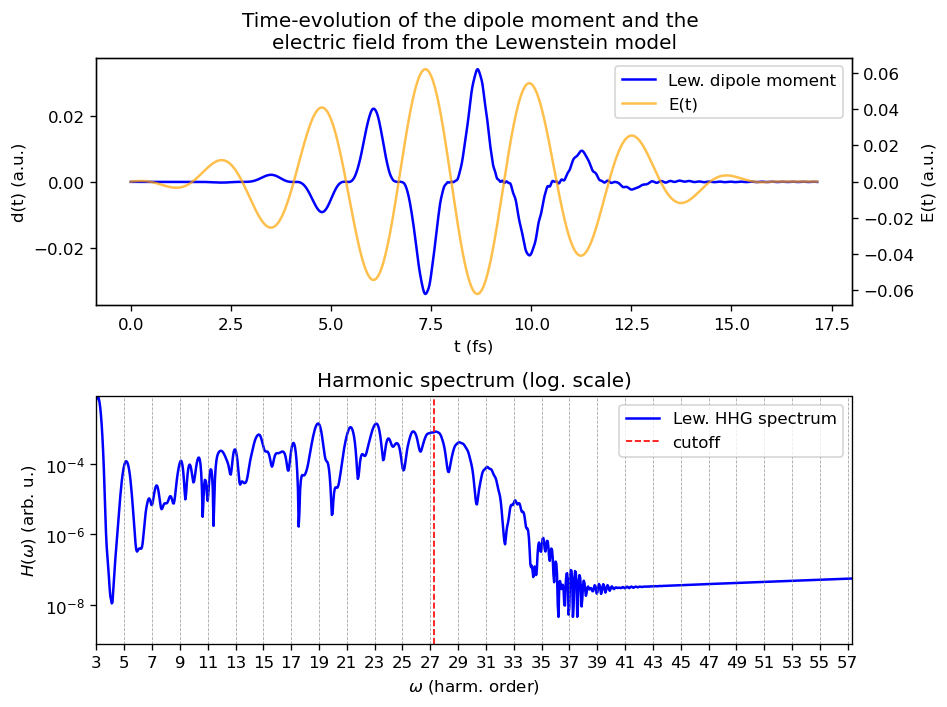

In [52]:
# plot the laser field and the dipole moment VS time
fig, (axt, axw) = plt.subplots(2,1, figsize=(8,6))
axl = axt.twinx()
p1lw, = axt.plot(t_si, d_lew, 'blue', label='Lew. dipole moment')
p2, = axl.plot(t_si, E_au, 'orange', alpha=0.7, label='E(t)')
axt.set_xlabel('t (fs)')
axt.set_ylabel('d(t) (a.u.)')
axl.set_ylabel('E(t) (a.u.)')
axt.set_title("Time-evolution of the dipole moment and the \nelectric field from the Lewenstein model")
axl.legend(handles=[p1lw, p2])

# plot the HHG spectra
p3lw, = axw.plot(ho, hhg_lew, 'blue', label='Lew. HHG spectrum')
# p3td, = axw.plot(ho, hhg*1e-6, 'green', linestyle='--', linewidth=1.0, label='TDDFT HHG spectrum')
axw.set_xticks([1+2*i for i in range(50)])
axw.set_xlim(3, cutoff_ho+30)
axw.set_yscale('log')
axw.set_ylim(np.amax(hhg_lew)*1e-7, np.amax(hhg_lew))
for i in range(50):
    axw.axvline(1+2*i, linewidth=0.5, linestyle='--', color='gray', alpha=0.7)
p4 = axw.axvline(cutoff_ho, linewidth=1.0, linestyle='--', color='red', label='cutoff')
axw.set_xlabel(r'$\omega$ (harm. order)')
axw.set_ylabel(r'$H(\omega)$ (arb. u.)')
axw.set_title("Harmonic spectrum (log. scale)")
axw.legend(loc='upper right', handles=[p3lw, p4])

plt.tight_layout()

## HHG of Argon using a higher resolution calculation and a higher intensity

Now that we saw the above, we present an example of a run with higher resolution, to achieve actual publication quality. We use the following article as reference, where they also used Octopus TDDFT to simulate HHG on Ar:

> Influence of the polarization of a multielectron atom in a strong laser field on high-order harmonic generation, *Romanov et al., PRA, 101, 2020*, DOI: [10.1103/PhysRevA.101.013435](https://doi.org/10.1103/PhysRevA.101.013435)

While we can't attach the article due to legal reasons, we encourage you to read this paper, as it includes a nice summary of the TDDFT method related to HHG. In this publication, a λ=800nm, tp=5.34fs, and I=8×10^14 W/cm2 laser pulse was used. For the simulation, we use an absorbing spherical boundary with a 20 Angstrom radius, a denser grid (spacing = 0.18 angstrom), and a much finer timestep (0.00242 fs). This simulation takes much more time than the previous one.

You can take a look at the input files for the ground state (`inp_gs`) and the time-dependent ('inp_td') calculation in the `ar_hq_calc` folder.

In [34]:
pulse_I_2 = 8e14 #w/cm2
pulse_I_au2 = au_si_conv(pulse_I_2*1e4, 'I', 'au')
cutoff_au2 = get_au_cutoff(pulse_I_au2, pulse_omega_au, Ip_ev)
cutoff_ev2 = cutoff_au2 / EV_TO_AU
print(f"Estimated cutoff: {cutoff_ev2:.3f} eV", Ip_ev)

Estimated cutoff: 167.305 eV 15.759


In [50]:
tl_au2, vecpot_au2 = np.genfromtxt(os.path.join(notebook_path, "ar_hq_calc", "laser"), usecols=(1,4), unpack=True)
E_au2 = np.gradient(vecpot_au2, tl_au2) / C_AU

fpath2 = os.path.join(notebook_path, "ar_hq_calc", "acceleration")
t_au2, dax2, day2,daz2 = np.genfromtxt(fpath2, usecols=(1,2,3,4), unpack=True, skip_header=5)
dipole_acc2 = daz2

# do the fft
n_fft2 = 3*len(t_au2)
dt_au2 = t_au2[1] - t_au2[0]
oms_au2 = 2*np.pi*fftshift(fftfreq(n_fft2,d = np.abs(dt_au2))) # FFT angular frequency
ft_da2 = fftshift(fft(dipole_acc2, n=n_fft2))
hhg_a2 = np.abs(ft_da2)**2

# ho2 = oms_au2 / pulse_omega_au
oms_ev2 = oms_au2 * 27.2
t_si2 = t_au2 / FS_TO_AU
tl_si2 = tl_au2 / FS_TO_AU


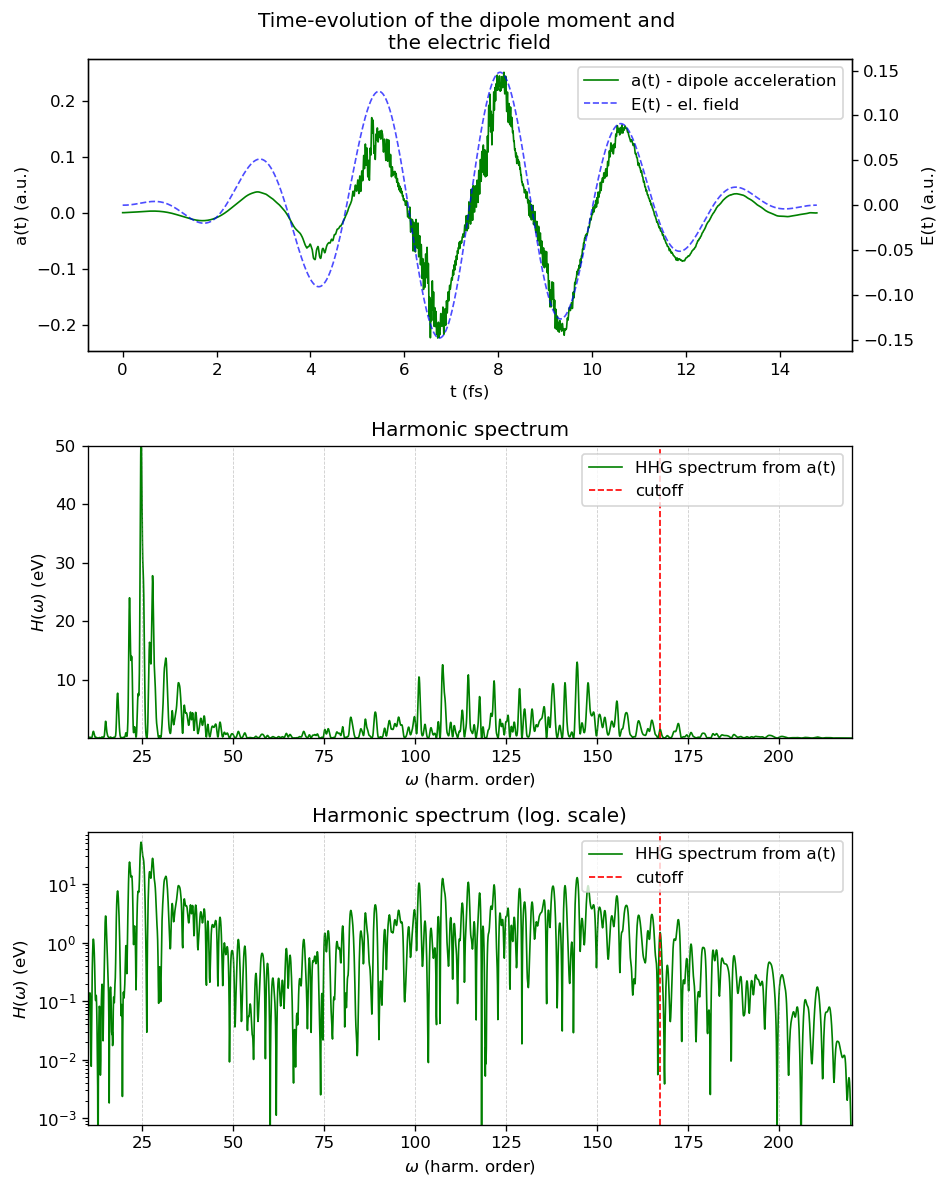

In [51]:
# plot the laser field and the dipole moment VS time
fig, (axt, axw, axwl) = plt.subplots(3,1, figsize=(8,10))
axl = axt.twinx()
p11, = axt.plot(t_si2, dipole_acc2, 'green', linewidth=1.0, label='a(t) - dipole acceleration')
p2, = axl.plot(tl_si2, E_au2, 'blue', alpha=0.7, linestyle='--', linewidth=1.0, label='E(t) - el. field')
axt.set_xlabel('t (fs)')
axt.set_ylabel('a(t) (a.u.)')
axl.set_ylabel('E(t) (a.u.)')
axt.set_title("Time-evolution of the dipole moment and \nthe electric field")
axl.legend(handles=[p11, p2])

# plot the HHG spectra
for ax in (axw, axwl):
    p31, = ax.plot(oms_ev2, hhg_a2, 'green', linewidth=1.0, label='HHG spectrum from a(t)')
    # ax.set_xticks([1+4*i for i in range(50)])
    ax.set_xlim(10, 220)
    for i in range(10):
        ax.axvline(25*i, linewidth=0.5, linestyle='--', color='gray', alpha=0.4)
    p4 = ax.axvline(cutoff_ev2, linewidth=1.0, linestyle='--', color='red', label='cutoff')
    ax.set_xlabel(r'$\omega$ (eV)')
    ax.set_ylabel(r'$H(\omega)$ (arb. units))')
    ax.legend(loc='upper right', handles=[p31, p4])

axw.set_title("Harmonic spectrum")
axwl.set_title("Harmonic spectrum (log. scale)")
axw.set_ylim(1e-2, 50)
axwl.set_ylim(np.amax(hhg_a2)*1e-8, np.amax(hhg_a2)*1e-3)
axwl.set_yscale('log')
plt.tight_layout()

This agrees nicely with the result found in the publication result:

![high resolution HHG reference](images/hhg_hires_ref.png "Reference HHG spectrum")
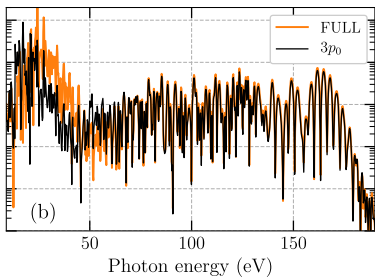

Let's compare again with the Lewenstein model:

In [37]:
wl_si = pulse_wl*const.nano
Ip_si = Ip_ev * const.electron_volt
t_si2 = au_si_conv(t_au2, 't', 'si')
E_si2 = au_si_conv(E_au2, 'E', 'si')
oms_si2 = au_si_conv(oms_au2, 'omega', 'si')

d_lew_si2 = pylew.lewenstein(t_si2, E_si2, Ip_si, wl_si, weights=np.ones_like(t_si), )
d_lew2 = au_si_conv(d_lew_si2, 'dipole', 'au')

ft_d_lew2 = - fftshift(fft(d_lew2, n=3*len(t_si2))) * oms_au2**2
hhg_lew2 = np.abs(ft_d_lew2)**2

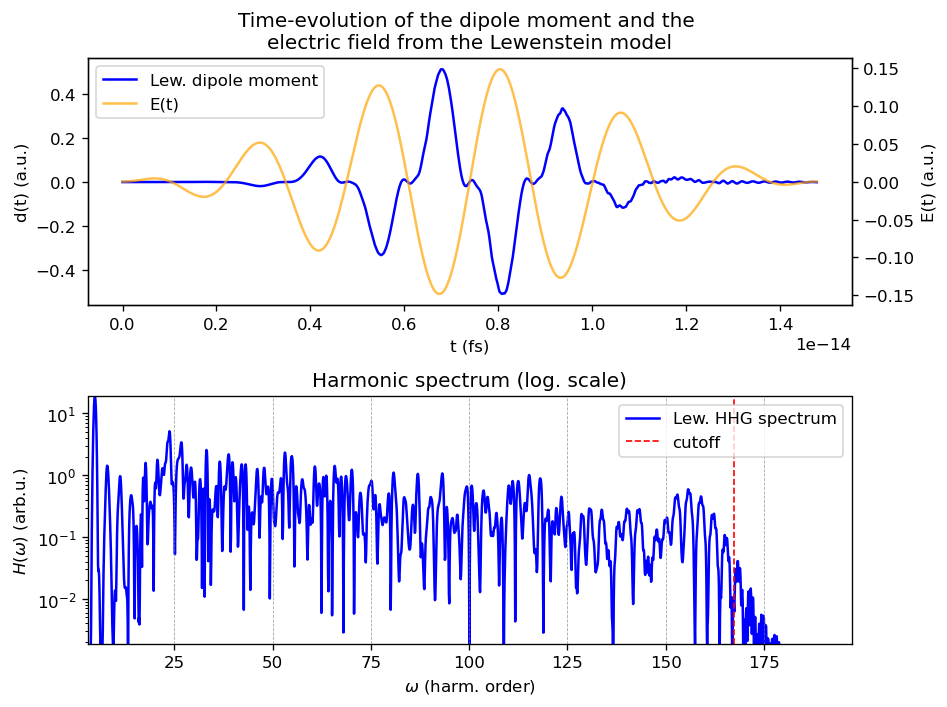

In [44]:
# plot the laser field and the dipole moment VS time
fig, (axt, axw) = plt.subplots(2,1, figsize=(8,6))
axl = axt.twinx()
p1lw, = axt.plot(t_si2, d_lew2, 'blue', label='Lew. dipole moment')
p2, = axl.plot(t_si2, E_au2, 'orange', alpha=0.7, label='E(t)')
axt.set_xlabel('t (fs)')
axt.set_ylabel('d(t) (a.u.)')
axl.set_ylabel('E(t) (a.u.)')
axt.set_title("Time-evolution of the dipole moment and the \nelectric field from the Lewenstein model")
axl.legend(handles=[p1lw, p2])

# plot the HHG spectra
p3lw, = axw.plot(oms_ev2, hhg_lew2, 'blue', label='Lew. HHG spectrum')
# p3td, = axw.plot(ho, hhg*1e-6, 'green', linestyle='--', linewidth=1.0, label='TDDFT HHG spectrum')
axw.set_xlim(3, cutoff_ev2+30)
axw.set_yscale('log')
axw.set_ylim(np.amax(hhg_lew2)*1e-4, np.amax(hhg_lew2))
for i in range(50):
    axw.axvline(25*i, linewidth=0.5, linestyle='--', color='gray', alpha=0.7)
p4 = axw.axvline(cutoff_ev2, linewidth=1.0, linestyle='--', color='red', label='cutoff')
axw.set_xlabel(r'$\omega$ (harm. order)')
axw.set_ylabel(r'$H(\omega)$ (arb.u.)')
axw.set_title("Harmonic spectrum (log. scale)")
axw.legend(loc='upper right', handles=[p3lw, p4])

plt.tight_layout()

We can see that the Lewenstein model captures the main properties, such as the plateu and the cutoff. However, it fails to predict, for example, the local minimum around 50eV. This is the so-called Cooper-minimum, and is related to a vanishing element of the electronic dipole matrix [*S. Varró, Photonics 2021, 8(7), 269, [10.1103/10.3390/photonics8070269](https://doi.org/10.3390/photonics8070269)*].

# TDDFT calculation on $\mathrm{N}_2$ molecule

In [36]:
os.chdir(notebook_path)

Now that we saw the TDDFT calculation on an atomistic case, let's try a bit different, using an N2 molecule. We follow similar steps as before.

The input file for the ground state calculation is given in directory under the name test_octopus. 

OR

You can create this directory here:

In [37]:
tmpdir_N2=os.path.abspath(os.path.join(notebook_path, 'calc_N2'))
# Make new directory
if not os.path.isdir(tmpdir_N2):
    os.makedirs(tmpdir_N2)
    print('Created calculation directory: '+ tmpdir_N2)
else:
    print('Using existing directory ' + tmpdir_N2)

Using existing directory /media/ezio/Ventoy/Work/ASE_Octopus_Demo/calc_N2


In [38]:
os.chdir(tmpdir_N2)

## Ground-state calculation for $\mathrm{N}_2$

We use the following geometrical coordinates for the molecule, and write it to an XYZ file using ASE:
```
2

N      -0.66044100      -0.00736549       0.00000000
N       0.29863339       0.51058848       0.00000000

0
```

In [39]:
from ase import Atoms, io
n2_mol = Atoms(('N','N'), ((-0.66044100, -0.00736549, 0.00000000), (0.29863339, 0.51058848, 0.00000000)))
xyz_path = os.path.join(tmpdir_N2, 'N2.xyz')
io.write(xyz_path, n2_mol, format='xyz')
# with open(Oct_dir+'\\N2.xyz','w') as N2_geo:
    # N2_geo.write('2 \n \n N -0.66044100 -0.00736549 0.00000000 \n N 0.29863339 0.51058848 0.00000000')

Let's verify what did we get.

In [42]:
with open(xyz_path, 'r') as f:
    print(f.read())

2

N      -0.660441000000000     -0.007365490000000      0.000000000000000
N       0.298633390000000      0.510588480000000      0.000000000000000



Time to run the ground state step. Octopus code executes the command with input file name as 'inp'. Hence, for ground state calculations we copy the file 'N2.gs.inp' to 'inp'.

The input file:

```
CalculationMode = gs
Dimensions = 3
fromScratch = yes

**#Shape of the simulation box**
BoxShape = sphere

**#In the original reference, the spacing is 0.25 a.u.**
Spacing = 0.35

**#In the original reference, the box is 300 a.u. long. p**
Radius = 200.0

**#We use Kohn Sham method**
TheoryLevel = kohn_sham

**#Coordinates for N2 molecule**
XYZCoordinates = "N2.xyz"

**#Maximum number of iterations for SCF calculations**
MaximumIter = 300

**#Boundaries of the simulation box absorbing defined with mask function.**
AbsorbingBoundaries = mask

**#Specifies the boundary width**
AbWidth = 50
```


In [43]:
inp_file = '''
CalculationMode = gs 
Dimensions = 3 
fromScratch = yes 
BoxShape = sphere 
Spacing = 0.35 
Radius = 200.0 
#We use Kohn Sham method 
TheoryLevel = kohn_sham 
#Coordinates for N2 molecule 
XYZCoordinates = "N2.xyz" 
#Maximum number of iterations for SCF calculations 
MaximumIter = 300 
#Boundaries of the simulation box absorbing defined with mask function. 
AbsorbingBoundaries = mask 
#Specifies the boundary width 
AbWidth = 50 
'''
gs_fpath = os.path.join(tmpdir_N2, 'N2.gs.inp')
try:
    shutil.copyfile(gs_fpath, os.path.join(tmpdir_N2, 'inp'))
except:
    with open(gs_fpath,'w+') as f:
        print(inp_file, file=f)
    shutil.copyfile(gs_fpath, os.path.join(tmpdir_N2, 'inp'))

Again, if in any doubt about the input file parameters, you can use `oct-help` to look it up:

In [189]:
parameter_to_lookup = "XYZCoordinates"
os.system(f"oct-help -p " + parameter_to_lookup)

Variable: XYZCoordinates
Type:     string
Section:  System::Coordinates
Description:
    If  PDBCoordinates is not present, the program reads the atomic coordinates
    from  the XYZ file specified by the variable XYZCoordinates -- in case this
    variable  is  present. The XYZ format is very simple: The first line of the
    file  has an integer indicating the number of atoms. The second can contain
    comments that are simply ignored by
    Octopus.  Then  there  follows  one  line per atom, containing the chemical
    species and the Cartesian coordinates of the atom.
    
    Units  and/or  UnitsInput, which means Octopus might expect xyz files to be
    in  atomic  units. If you want the XYZ file to be read in Angstrom, as most
    codes do, you can set the variable UnitsXYZFiles to
    angstrom.


0

Time to run the ground-state calculation (if you have time - for the lesson this is already done). This takes about 32 mins when run in serial, so the outputs are already included. You don't have to run this now, but, of course, feel free to try it outside the class.

In [45]:
run_gs_calc = False
if run_gs_calc:
    os.system("octopus | tee gs.log")

The output file for the ground state calculations is given in test_octopus directory as `gs.log`. 

The ouptup of the calculation will give several SCF iterations and end with:

#State  Eigenvalue (H) Occupation    Error

      1       -1.045563    2.000000   (2.6E-05)
      
      2       -0.505260    2.000000   (2.0E-05)
      
      3       -0.470952    2.000000   (3.8E-05)
      
      4       -0.406124    2.000000   (2.7E-06)
      
      5       -0.359920    2.000000   (3.1E-05)


The ionization potential of 0.36 Hartree (9.80eV) is a poor match for experimental value of [15.6eV](https://webbook.nist.gov/cgi/cbook.cgi?ID=C7727379&Mask=20). However, quantitative results is beyond the scope of this tutorial. The ionization potential value can be improved by using different method for calculation (see [M.R. Mack et al. 2013](https://doi.org/10.1016/j.cplett.2012.11.045)).

## Time-dependent calculation for $\mathrm{N}_2$

Now we run the time dependent (td) calculations:

The input file of the td calculations is given as 'N2.td.inp' which is present in the test directory. If not one can create using:
```
#This test calculates a three-dimensional model for nitrogen molecule, considering
CalculationMode = td
Debug = trace
Dimensions = 3
fromScratch = yes
PseudopotentialSet = pseudodojo_pbe
FilterPotentials = filter_none
XYZCoordinates = "N2.xyz"
BoxShape = sphere
Radius = 50*angstrom
Spacing = 0.3*angstrom

TheoryLevel = kohn_sham
#Frequency corresponding to 800nm.
omega = 0.05655
period = 0.6*femtosecond #*pi/omega

#In the original reference, there are 96 cycles instead of 8.
stime = 30*period

#The time-step is shorter in the original reference. But the propagation
#algorithm is also probably different.
dt = period/100
TDPropagationTime = stime
TDPropagator = exp_mid
TDExponentialMethod = lanczos
TDExpOrder = 20
TDTimeStep = dt
%TDExternalFields
electric_field   | 1 | 0 | 0 | omega | "envelope_function"
%
electric_amplitude = (sqrt(4*10^14)/sqrt(3.509470*10^16))
%TDFunctions
"envelope_function" | tdf_from_expr | "electric_amplitude*(sin(pi/stime*t))^2"
%
#AbsorbingBoundaries = cap
AbsorbingBoundaries = mask
AbWidth = 50
%TDOutput 
 laser
 multipoles 
 dipole_acceleration
%
```

In [46]:
td_inp = '''
CalculationMode = td 
Debug = trace 
Dimensions = 3 
fromScratch = yes 
PseudopotentialSet = pseudodojo_pbe 
FilterPotentials = filter_none 
XYZCoordinates = "N2.xyz" 
BoxShape = sphere 
Radius = 50*angstrom 
Spacing = 0.3*angstrom 
TheoryLevel = kohn_sham 

#Frequency corresponding to 800nm. 
omega = 0.05655 
period = 0.6*femtosecond 
#In the original reference, there are 96 cycles instead of 8. 
stime = 30*period 

dt = period/100 
TDPropagationTime = stime 
TDPropagator = exp_mid 
TDExponentialMethod = lanczos 
TDExpOrder = 20 
TDTimeStep = dt 
%TDExternalFields 
electric_field   | 1 | 0 | 0 | omega | "envelope_function" 
% 
electric_amplitude = (sqrt(4*10^14)/sqrt(3.509470*10^16)) 
%TDFunctions 
"envelope_function" | tdf_from_expr | "electric_amplitude*(sin(pi/stime*t))^2" 
% 
AbsorbingBoundaries = mask 
AbWidth = 50 
%TDOutput 
 laser 
 multipoles 
 dipole_acceleration 
%
'''
td_fpath = os.path.join(tmpdir_N2, 'N2.td.inp')
try:
    shutil.copyfile(td_fpath, os.path.join(tmpdir_N2, 'inp'))
except:
    with open(td_fpath,'w+') as f:
        print(inp_file, file=f)
    shutil.copyfile(td_fpath, os.path.join(tmpdir_N2, 'inp'))

To execute octopus td calculations, we again just execute the following in the terminal:

```
octopus | tee td.log 
```

This takes a long time though, so during the lesson, we will use the result of an already executed calculation. Feel free to run this calculation outside the lesson.

In [47]:
RUN_TD = False
if RUN_TD:
    os.system('octopus | tee td.log')

This time, we use Octopus's built-in tool do calculate the HHG spectrum:
```
oct-harmonic-spectrum -m 1
```
which processes the dipole results in a similar way we did. It would use the data of the TD run, which is quite big and is therefore not attached to this tutorial; but you can get it by executing the Octopus runs above.

In [48]:
CALC_HARM = False
if CALC_HARM:
    os.system('oct-harmonic-spectrum -m 1')

This command will generate the `hs-mult.x` file. 

The hs-mult.x file contains:
#w                  H(w) 

#H             (b/hbar/H^2 

   0.000000E+00   0.335852E-03
   
   0.514091E-02   0.402734E-03
   
   0.102818E-01   0.863577E-03
   
   0.154227E-01   0.328424E-04
   
$\dots \dots$ 

Plotting the hs-mult.x file, we get the harmonic generation dipole power spectrum.

/media/ezio/Ventoy/Work/ASE_Octopus_Demo/calc_N2/hs-mult.x


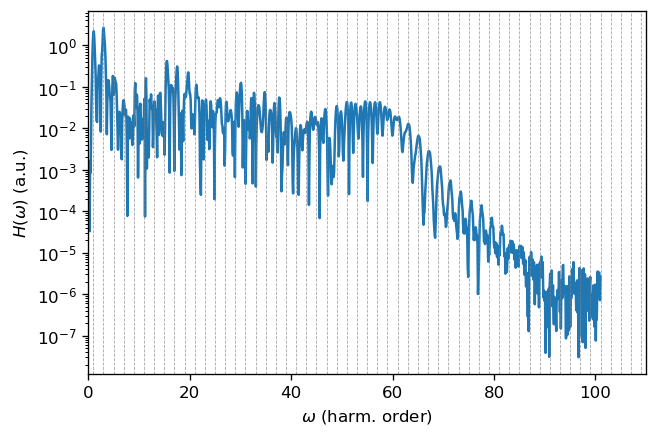

In [52]:
hs_file = os.path.join(tmpdir_N2, 'hs-mult.x')
print(hs_file)
df = pd.read_csv(hs_file,header=None,skiprows=2, delim_whitespace=True)
plt.semilogy(df[0]/0.056,df[1],label='N2')
plt.xlabel(r'$\omega$ (harm. order)')
plt.ylabel(r'$H(\omega)$ (a.u.)')
plt.xlim(0, 110)
for i in range(55):
    plt.axvline(1+2*i, linewidth=0.5, linestyle='--', color='gray', alpha=0.7)